# Import packages

In [1]:
import numpy as np
import pandas as pd
import operator
import statistics as stat
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

# Load Boston Housing dataset, display target prices with respect to each feature

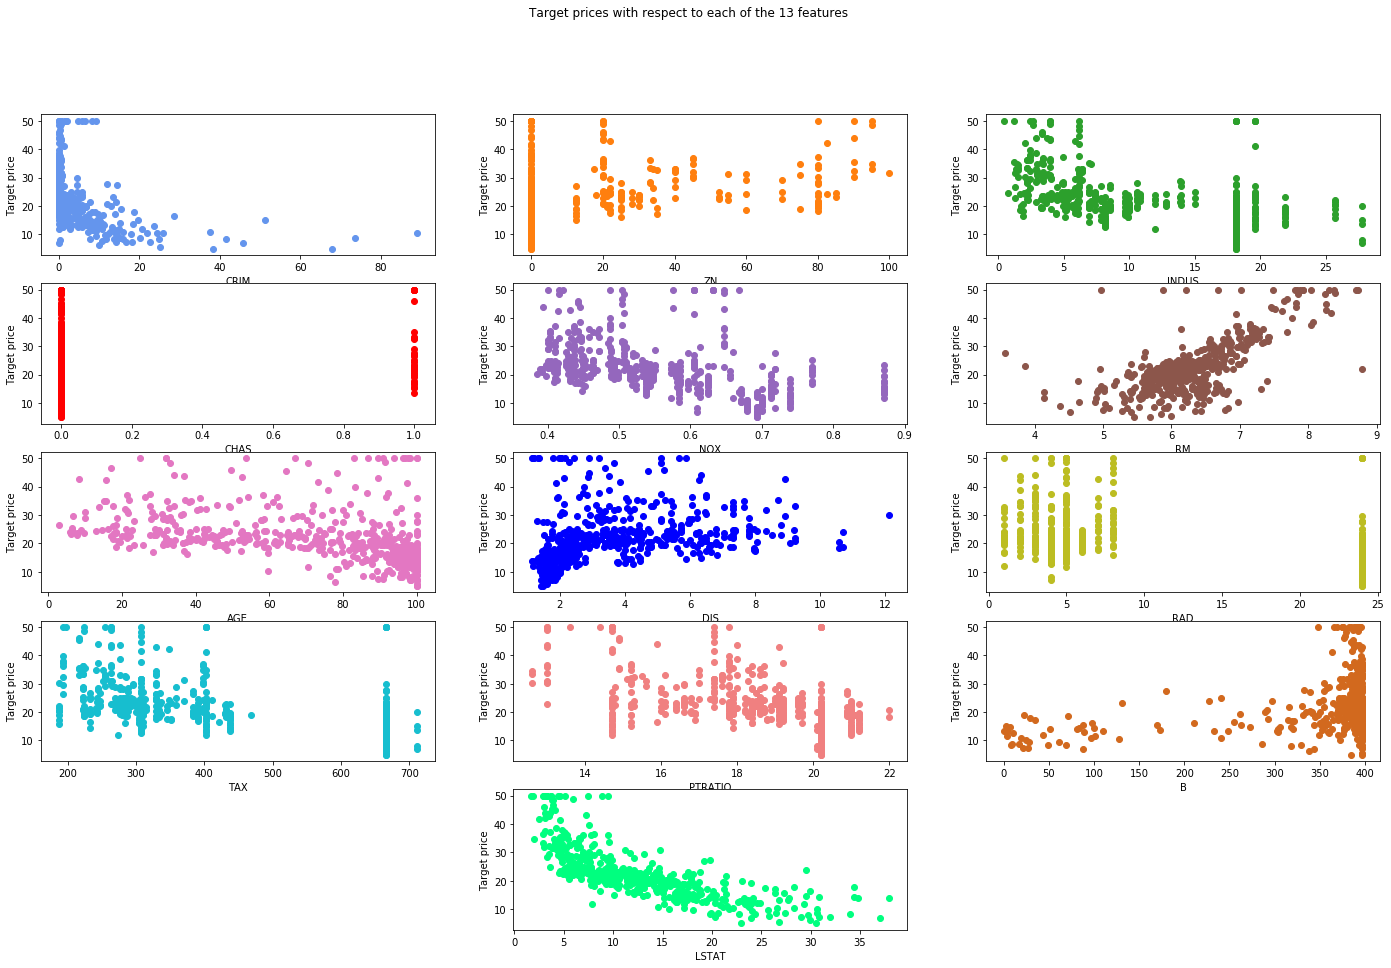

In [2]:
### Load Boston dataset (store the features in a matrix X, and the target prices in a vector Y):
boston = load_boston()
X = boston.data
y = boston.target

# Display scatterplots of target prices with respect to each of the 13 features:
colors = ['cornflowerblue',
          'tab:orange',
          'tab:green',
          'r',
          'tab:purple',
          'tab:brown',
          'tab:pink',
          'b',
          'tab:olive',
          'tab:cyan',
          'lightcoral',
          'chocolate',
          'springgreen']
for col in range(X.shape[1]):
    plt.figure(1, figsize=(24, 15))
    if col < X.shape[1] - 1:
        plot_idx = col+1
    else:
        plot_idx = 14
    plt.subplot(5, 3, plot_idx)
    plt.scatter(X[:,col], y, marker='o', c=colors[col])
    plt.xlabel(boston.feature_names[col])
    plt.ylabel('Target price')
plt.suptitle("Target prices with respect to each of the 13 features")
plt.show()

# Finish implementing model selection of a Ridge model on a list of hyper-parameters instances with KFold cross-validation

In [3]:
### Split+shuffle X and Y into k=num_folds different folds:
def KFold_split(X, Y, num_folds, seed):
    KFold_splitter = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    X_train_folds = []
    X_val_folds = []
    Y_train_folds = []
    Y_val_folds = []
    for (kth_fold_train_idxs, kth_fold_val_idxs) in KFold_splitter.split(X, Y):
        X_train_folds.append(X[kth_fold_train_idxs])
        X_val_folds.append(X[kth_fold_val_idxs])
        Y_train_folds.append(Y[kth_fold_train_idxs])
        Y_val_folds.append(Y[kth_fold_val_idxs])
    return X_train_folds, X_val_folds, Y_train_folds, Y_val_folds

In [4]:
### Select a Ridge model on a list of hyper-parameters instances, via Kfold cross-validation:
def KFold_model_selection(X, Y, hyper_parameters_instances, num_folds, seed):
    # Extract a test set:
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    # Extract train and validation folds:
    X_train_folds, X_val_folds, Y_train_folds, Y_val_folds = KFold_split(X_train_val, Y_train_val, num_folds, seed)
    # For each hyper-parameter instance, do KFold cross validation:
    mean_val_MSEs = []
    for hyper_parameters_instance in hyper_parameters_instances:
        print("\nNow preprocessing hyper-parameter instance", hyper_parameters_instance)
        mean_val_MSE = perform_KFold_CV(X_train_folds, X_val_folds, 
                                        Y_train_folds, Y_val_folds, 
                                        hyper_parameters_instance['degree'], 
                                        hyper_parameters_instance['regularization']
                                       )
        print("Mean validation MSE:", mean_val_MSE)
        mean_val_MSEs.append(mean_val_MSE)
        
        
    # The hyper-parameter instance with the smallest mean validation MSE is our model of choice:
    minMSE = min(mean_val_MSEs)
    best_instance_idx = mean_val_MSEs.index(minMSE)
    best_hyper_parameters_instance = hyper_parameters_instances[best_instance_idx]
    print("\n\nBest hyper-parameter instance:", best_hyper_parameters_instance)
    
    # Train and evaluate the best instance on the whole dataset:
    best_model_test_MSE = assess_Ridge(X_train_val, X_test, 
                                       Y_train_val, Y_test,
                                       best_hyper_parameters_instance['degree'],
                                       best_hyper_parameters_instance['regularization']
                                      )
    print("Test MSE:", best_model_test_MSE)

In [5]:
### KFold cross-validation of a Ridge model with given hyper-parameters:
def perform_KFold_CV(X_train_folds, X_val_folds, Y_train_folds, Y_val_folds, degree, regularization):
    val_fold_MSEs = []
    # For each fold, assess a surrogate model with fixed hyper-parameters:
    cmpt = 0
    for X_train_fold, X_val_fold, Y_train_fold, Y_val_fold in zip(X_train_folds, X_val_folds, Y_train_folds, Y_val_folds):
        val_fold_MSE = assess_Ridge(X_train_fold, X_val_fold, Y_train_fold, Y_val_fold, degree, regularization)
        cmpt += 1
        print("Surrogate model", str(cmpt) + "/" + str(len(X_val_folds)), "validation MSE:", val_fold_MSE)
        val_fold_MSEs.append(val_fold_MSE)
    # Compute the mean validation MSE between all the folds:
    mean_val_MSE = stat.mean(val_fold_MSEs)
    return mean_val_MSE

In [6]:
### Fit and evaluate a Ridge model with given hyper-parameters:
def assess_Ridge(X_train, X_test, Y_train, Y_test, degree, regularization):
    # Build the polynomial features:
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.fit_transform(X_test)
    # Fit the polynomial features with a Ridge model:
    model = Ridge(alpha=regularization)
    model.fit(X_train_poly, Y_train)
    # Evaluate the Ridge model on the test set:
    Y_test_pred = model.predict(X_test_poly)
    test_MSE = mean_squared_error(Y_test_pred, Y_test)
    return test_MSE

# Perform model selection of a Ridge model on a list of hyper-parameters instances with KFold cross-validation

In [7]:
### Model selection of a Ridge model on a list of hyper-parameters instances with KFold cross-validation:
# Fix random seed for reproducibility:
seed = 666
# Create the list of hyper-parameters instances:
hyper_parameters_instances = [{"degree": 1, "regularization": 0},
                              {"degree": 2, "regularization": 0},
                              {"degree": 3, "regularization": 0},
                              {"degree": 1, "regularization": 0.001},
                              {"degree": 2, "regularization": 0.001},
                              {"degree": 3, "regularization": 0.001},
                              {"degree": 1, "regularization": 0.01},
                              {"degree": 2, "regularization": 0.01},
                              {"degree": 3, "regularization": 0.01},
                              {"degree": 1, "regularization": 0.1},
                              {"degree": 2, "regularization": 0.1},
                              {"degree": 3, "regularization": 0.1},
                              {"degree": 3, "regularization": 1000}]
# Select model with KFold cross-validation:
KFold_model_selection(X, y, hyper_parameters_instances, 5, seed)


Now preprocessing hyper-parameter instance {'degree': 1, 'regularization': 0}
Surrogate model 1/5 validation MSE: 35.82835210879788
Surrogate model 2/5 validation MSE: 19.43226467176391
Surrogate model 3/5 validation MSE: 37.60518953135884
Surrogate model 4/5 validation MSE: 15.35938040025388
Surrogate model 5/5 validation MSE: 13.253058923142865
Mean validation MSE: 24.295649127063474

Now preprocessing hyper-parameter instance {'degree': 2, 'regularization': 0}
Surrogate model 1/5 validation MSE: 42.56505837488224
Surrogate model 2/5 validation MSE: 11.772259784211705
Surrogate model 3/5 validation MSE: 18.28665900932174
Surrogate model 4/5 validation MSE: 12.33703037566928
Surrogate model 5/5 validation MSE: 10.176807815712529
Mean validation MSE: 19.0275630719595

Now preprocessing hyper-parameter instance {'degree': 3, 'regularization': 0}


/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Surrogate model 1/5 validation MSE: 934.9522841651553
Surrogate model 2/5 validation MSE: 3334.8108363188117
Surrogate model 3/5 validation MSE: 197.81219896636748


/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.01508e-17): result may not be accurate.
  overwrite_a=True).T
/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.09818e-17): result may not be accurate.
  overwrite_a=True).T
/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.44349e-17): result may not be accurate.
  overwrite_a=True).T
/usr/lib/python3.

Surrogate model 4/5 validation MSE: 6566.425179991057
Surrogate model 5/5 validation MSE: 279.10801598169246
Mean validation MSE: 2262.621703084617

Now preprocessing hyper-parameter instance {'degree': 1, 'regularization': 0.001}
Surrogate model 1/5 validation MSE: 35.82872944646623
Surrogate model 2/5 validation MSE: 19.432307840398032
Surrogate model 3/5 validation MSE: 37.606378210915054
Surrogate model 4/5 validation MSE: 15.35882441429881
Surrogate model 5/5 validation MSE: 13.253719371506952
Mean validation MSE: 24.295991856717016

Now preprocessing hyper-parameter instance {'degree': 2, 'regularization': 0.001}
Surrogate model 1/5 validation MSE: 45.08207949158216
Surrogate model 2/5 validation MSE: 12.7127862915116
Surrogate model 3/5 validation MSE: 18.264781187937395
Surrogate model 4/5 validation MSE: 12.336052247175253
Surrogate model 5/5 validation MSE: 9.696307438999906
Mean validation MSE: 19.618401331441262

Now preprocessing hyper-parameter instance {'degree': 3, 'reg

/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Surrogate model 1/5 validation MSE: 934.9522841651553
Surrogate model 2/5 validation MSE: 3334.8108363188117
Surrogate model 3/5 validation MSE: 197.81219896636748


/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Surrogate model 4/5 validation MSE: 6566.425179991057
Surrogate model 5/5 validation MSE: 279.10801598169246
Mean validation MSE: 2262.621703084617

Now preprocessing hyper-parameter instance {'degree': 1, 'regularization': 0.01}
Surrogate model 1/5 validation MSE: 35.83216236004271
Surrogate model 2/5 validation MSE: 19.432817223259722
Surrogate model 3/5 validation MSE: 37.617055626519196
Surrogate model 4/5 validation MSE: 15.35416519632733
Surrogate model 5/5 validation MSE: 13.259673398101473
Mean validation MSE: 24.299174760850086

Now preprocessing hyper-parameter instance {'degree': 2, 'regularization': 0.01}
Surrogate model 1/5 validation MSE: 49.604727031487236
Surrogate model 2/5 validation MSE: 13.099663590859423
Surrogate model 3/5 validation MSE: 18.276145172072216
Surrogate model 4/5 validation MSE: 11.948130086325225
Surrogate model 5/5 validation MSE: 8.75722635831431
Mean validation MSE: 20.33717844781168

Now preprocessing hyper-parameter instance {'degree': 3, 'regu

/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Surrogate model 1/5 validation MSE: 934.9522841651553
Surrogate model 2/5 validation MSE: 3334.8108363188117


/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Surrogate model 3/5 validation MSE: 197.81219896636748
Surrogate model 4/5 validation MSE: 6566.425179991057
Surrogate model 5/5 validation MSE: 279.10801598169246
Mean validation MSE: 2262.621703084617

Now preprocessing hyper-parameter instance {'degree': 1, 'regularization': 0.1}
Surrogate model 1/5 validation MSE: 35.86912844018722
Surrogate model 2/5 validation MSE: 19.447564949522942
Surrogate model 3/5 validation MSE: 37.72062365976495
Surrogate model 4/5 validation MSE: 15.334988641861225
Surrogate model 5/5 validation MSE: 13.319475004967737
Mean validation MSE: 24.338356139260814

Now preprocessing hyper-parameter instance {'degree': 2, 'regularization': 0.1}
Surrogate model 1/5 validation MSE: 42.107603078436185
Surrogate model 2/5 validation MSE: 13.191256719594227
Surrogate model 3/5 validation MSE: 19.091786392734075
Surrogate model 4/5 validation MSE: 12.306188948649407
Surrogate model 5/5 validation MSE: 7.305852692556674
Mean validation MSE: 18.800537566394112

Now pre

/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


Surrogate model 2/5 validation MSE: 3303.905306584452
Surrogate model 3/5 validation MSE: 190.2908678578281
Surrogate model 4/5 validation MSE: 4692.463757042396


/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.45575e-17): result may not be accurate.
  overwrite_a=False)


Surrogate model 5/5 validation MSE: 277.69350056876476
Mean validation MSE: 1879.886311181069

Now preprocessing hyper-parameter instance {'degree': 3, 'regularization': 1000}
Surrogate model 1/5 validation MSE: 508.1232523409543
Surrogate model 2/5 validation MSE: 1534.0112452169742
Surrogate model 3/5 validation MSE: 205.66240212800636
Surrogate model 4/5 validation MSE: 2778.849553590262
Surrogate model 5/5 validation MSE: 214.79047953932226
Mean validation MSE: 1048.2873865631038


Best hyper-parameter instance: {'degree': 2, 'regularization': 0.1}
Test MSE: 15.698644556867206


/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.43417e-17): result may not be accurate.
  overwrite_a=False)
/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.7359e-17): result may not be accurate.
  overwrite_a=False)
/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.5224e-17): result may not be accurate.
  overwrite_a=False)
/usr/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.79631e-17): result may not be accurate.
  overwrite_a=False)
